In [0]:
!pip install requests


In [0]:
!pip install psycopg2-binary

     |████████████████████████████████| 2.9MB 9.3MB/s 


In [0]:
import datetime
from os import getcwd, chdir, listdir
from scipy.stats import trim_mean as tm
from scipy.stats import bartlett

# Estruturas de datos:
import pandas as pd
import numpy as np

# Visuaizaciones:
import matplotlib.pyplot as plt
import seaborn as sns

# Conecciones y consumo de APIs
import requests
import psycopg2

In [0]:
# Formato de los gráficos:
sns.set(style='whitegrid')

## 1) Obtener Datos de la API

 Obtenga los datos de todos los sismos ocurridos entre el 1 de Enero del 2010 y el día 5 de Diciembre del 2019, que tengan una magnitud mínima de 5 grados, en formato JSON (para efectos de la API, el formato a solicitar es el llamado “geojson”).mundo. Toda la documentación de la API en cuestión se encuentra en https://earthquake.usgs.gov/fdsnws/event/1/.

Para la obtención de los datos solicitados, se puede recurrir a la librería request, y para transformar aquella información en una variable de tipo diccionario, se puede utilizar la librería json. Lo anterior debería entregarle un diccionario con otros diccionarios al interior.


In [0]:
# URL con parámetros para obtener sismos entre el 1 de enero 2010 y el
# 5 de diciembre del 2019:
url = 'https://earthquake.usgs.gov/fdsnws/event/1/query?format=geojson&'\
      'starttime=2010-01-01&endtime=2019-12-05&minmagnitude=5'

# Request a la API:
r = requests.get(url)
r

<Response [200]>

In [0]:
# Se extrae el json con la información:
features = r.json()['features']

## 2) Generar DataFrame
A partir de la información disponible en el diccionario generado, construya un DataFrame que muestre los registros de cada uno de los sismos antes mencionados. 

Puede resultar conveniente obtener el número de registros extraídos disponible en el subdiccionario “metadata”, y recorrer el subdiccionario “features” con aquella información.


In [0]:
info = []
for i in range(len(features)):
  info.append(list(features[i]['properties'].values()))

In [0]:
df_earthquake = pd.DataFrame(info, columns=features[0]['properties'].keys())
df_earthquake.head()

,mag,place,time,updated,tz,url,detail,felt,cdi,mmi,alert,status,tsunami,sig,net,code,ids,sources,types,nst,dmin,rms,gap,magType,type,title
0,6.0,"63km NNE of Isangel, Vanuatu",1575490203614,1575589441300,660.0,https://earthquake.usgs.gov/earthquakes/eventp...,https://earthquake.usgs.gov/fdsnws/event/1/que...,1.0,2.7,3.378,green,reviewed,0,554,us,60006m2j,",us60006m2j,",",us,",",dyfi,geoserve,ground-failure,losspager,moment...",NaN,2.812,0.82,21.0,mww,earthquake,"M 6.0 - 63km NNE of Isangel, Vanuatu"
1,5.0,"44km S of Jarm, Afghanistan",1575449176621,1575451889499,270.0,https://earthquake.usgs.gov/earthquakes/eventp...,https://earthquake.usgs.gov/fdsnws/event/1/que...,2.0,2.2,NaN,None,reviewed,0,385,us,60006lwg,",us60006lwg,",",us,",",dyfi,geoserve,origin,phase-data,",NaN,1.257,0.93,60.0,mb,earthquake,"M 5.0 - 44km S of Jarm, Afghanistan"
2,5.0,"14km ENE of Daigo, Japan",1575423536116,1575759727439,540.0,https://earthquake.usgs.gov/earthquakes/eventp...,https://earthquake.usgs.gov/fdsnws/event/1/que...,60.0,5.0,NaN,None,reviewed,0,415,us,60006lu8,",us60006lu8,",",us,",",dyfi,geoserve,origin,phase-data,",NaN,1.835,0.83,97.0,mb,earthquake,"M 5.0 - 14km ENE of Daigo, Japan"
3,5.2,"110km ESE of Shikotan, Russia",1575415507181,1575496992040,600.0,https://earthquake.usgs.gov/earthquakes/eventp...,https://earthquake.usgs.gov/fdsnws/event/1/que...,NaN,NaN,NaN,None,reviewed,0,416,us,60006lt9,",us60006lt9,",",us,",",geoserve,moment-tensor,origin,phase-data,",NaN,3.751,0.73,135.0,mww,earthquake,"M 5.2 - 110km ESE of Shikotan, Russia"
4,5.6,"70km S of Kavieng, Papua New Guinea",1575411792789,1575498340020,600.0,https://earthquake.usgs.gov/earthquakes/eventp...,https://earthquake.usgs.gov/fdsnws/event/1/que...,NaN,NaN,5.126,green,reviewed,1,482,us,60006lsm,",us60006lsm,",",us,",",geoserve,losspager,moment-tensor,origin,phase...",NaN,1.691,0.64,37.0,mww,earthquake,"M 5.6 - 70km S of Kavieng, Papua New Guinea"


## 3) Graficar

Genere con exactitud los siguientes dos gráficos para explorar el DataFrame indicado:

Gráfico de barras horizontal que entregue los 25 lugares con mayor frecuencia de sismos en la década. Explore formas de cómo truncar la cantidad de datos a los 25 con mayor frecuencia.

Histograma que muestre la distribución de sismos entre 6 grados y el máximo observado. Explore cómo fijar los márgenes del gráfico para que no se muestren en el eje x valores menores a 6 grados)

Genere además, un tercer gráfico que considere relevante para estos efectos, y explique las razones del porqué lo eligió.


### Gráfico de Barras Horizontales

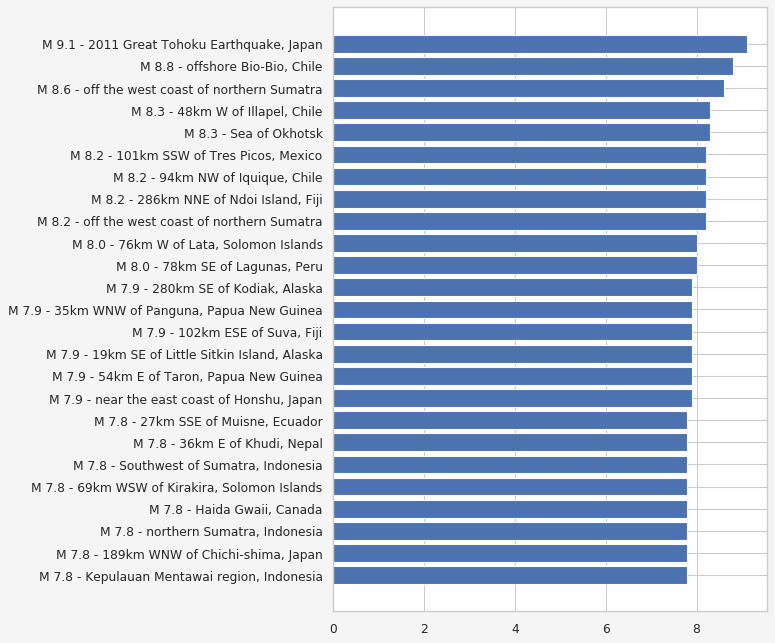

In [0]:
# Configuración del gráfico:
fig = plt.figure(num=None, figsize=(7, 10), dpi=80, facecolor='whitesmoke', 
                   edgecolor='k')

# Se seleccinan solo las columnas con la magnitud y el título:
mag_title_df = df_earthquake[['mag','title']]
# Se ordenan y seleccionan los 25 con mayor magnitud:
selected = mag_title_df.sort_values('mag').iloc[-25:,:]
# Creación gráfico:
plt.barh(selected.title, selected.mag)
plt.show()


### 3.2) Histograma

Histograma que muestre la distribución de sismos entre 6 grados y el máximo observado. Explore cómo fijar los márgenes del gráfico para que no se muestren en el eje x valores menores a 6 grados)

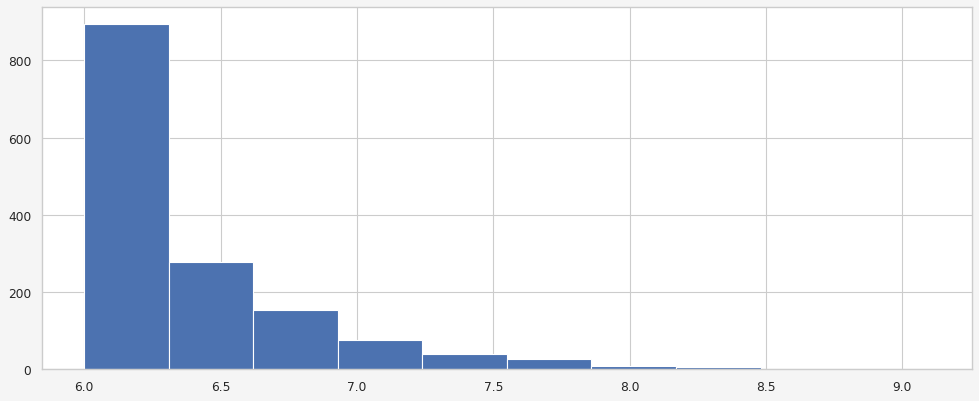

In [0]:
# Se crea el gráfico:
fig = plt.figure(num=None, figsize=(15, 6), dpi=80, facecolor='whitesmoke', 
                   edgecolor='k')
mag_title_df.mag[mag_title_df.mag >= 6].hist()


### 3.3) Otro Gráfico

## 4) Creación de las Columnas de Fecha y Hora  

Note que la columna “time” no está en formato “año/mes/dia hora/min/seg”. Para poder trabajar de mejor manera aquel dato, genere 6 nuevas columnas en el DataFrame, en la cual se guarden año, mes, dia, hora, min y seg de cada evento.

In [0]:
# Se calculan los segundos:
seconds = df_earthquake.time / 1000

# Se crea un diccionario con el nombre de la columna y el comando para el valor:
date_val = {'year': 'Y',
            'month': 'm',
            'day': 'd',
            'hour': 'I',
            'minute': 'M',
            'second': 'S'}

# Se crean las nuevas columnas con los datos de a fecha y hora:
for val in date_val.keys():
  df_earthquake[val] = list(map(lambda x: datetime.datetime.fromtimestamp(x)\
                                .strftime('%'+date_val[val]), seconds))

In [0]:
df_earthquake[['year','month','day','hour','minute','second']]

,year,month,day,hour,minute,second
0,2019,12,04,08,10,03
1,2019,12,04,08,46,16
2,2019,12,04,01,38,56
3,2019,12,03,11,25,07
4,2019,12,03,10,23,12
...,...,...,...,...,...,...
18235,2010,01,01,02,31,10
18236,2010,01,01,09,37,11
18237,2010,01,01,02,34,56
18238,2010,01,01,02,22,23


## 5) Construya dos nuevas columnas binarias:

Una columna que tome valor 1 cuando el sismo ocurrió en Chile y tome valor 0 si no

Una columna que tome valor 1 si el sismo tuvo una magnitud mayor que 6 grados y 0 si no.


In [0]:
 # Columna binaria de ocurrencia en Chile:
 df_earthquake['in_chile'] = list(map(lambda x: int('Chile' in x),  
                                      df_earthquake.place))
 
 # Columna binaria de magnitud mayor a 6:
 df_earthquake['mag_gt_6'] = list(map(lambda x: int(x > 6),  df_earthquake.mag))

## 6) Nuevo DataFrame seleccionando columnas:

Genere un nuevo DataFrame a partir del anterior, manteniendo solo las siguientes columnas:

- code
- mag
- alert
- place
- sig
- tsunami
- title
- las 6 columnas construidas en el punto 4.
- las 2 columnas binarias construidas en el punto 5.


In [0]:
# Lista de columnas seleccionadas:
columns = ['code', 'mag', 'alert', 'place', 'sig', 'tsunami', 'title', 'year',
           'month','day','hour','minute','second', 'in_chile', 'mag_gt_6']

# Se crea el nuevo DataFrame en base a las columnas seleccionadas:
new_earthqk = df_earthquake[columns]

# Se cambia e tipo de las columnas numéricas para que sean tomadas como enteros:
new_earthqk = pd.concat([new_earthqk.loc[:,:'title'], new_earthqk\
                         .loc[:,'year':].astype('int')], axis=1)

new_earthqk.head()

,code,mag,alert,place,sig,tsunami,title,year,month,day,hour,minute,second,in_chile,mag_gt_6
0,60006m2j,6.0,green,"63km NNE of Isangel, Vanuatu",554,0,"M 6.0 - 63km NNE of Isangel, Vanuatu",2019,12,4,8,10,3,0,0
1,60006lwg,5.0,None,"44km S of Jarm, Afghanistan",385,0,"M 5.0 - 44km S of Jarm, Afghanistan",2019,12,4,8,46,16,0,0
2,60006lu8,5.0,None,"14km ENE of Daigo, Japan",415,0,"M 5.0 - 14km ENE of Daigo, Japan",2019,12,4,1,38,56,0,0
3,60006lt9,5.2,None,"110km ESE of Shikotan, Russia",416,0,"M 5.2 - 110km ESE of Shikotan, Russia",2019,12,3,11,25,7,0,0
4,60006lsm,5.6,green,"70km S of Kavieng, Papua New Guinea",482,1,"M 5.6 - 70km S of Kavieng, Papua New Guinea",2019,12,3,10,23,12,0,0


In [0]:
new_earthqk.dtypes

code         object
mag         float64
alert        object
place        object
sig           int64
tsunami       int64
title        object
year          int64
month         int64
day           int64
hour          int64
minute        int64
second        int64
in_chile      int64
mag_gt_6      int64
dtype: object

## 7) Genere tres DataFrames donde cada uno almacene los sismos de los años 2010, 2015 y 2018 respectivamente. 

Expórtelos en 3 csv distintos. Nombrelos como “earthquakes_mag6_2010.csv”, “earthquakes_mag6_2015.csv” y “earthquakes_mag6_2018.csv” respectivamente.

In [0]:
years = [2010, 2015, 2018]

# Se crean los DataFrames y los archivos ".csv" para cada año:
for y in years:
  new_earthqk[new_earthqk.year == y].to_csv(index=False, sep=';', 
                                            path_or_buf=\
                                            f'earthquakes_mag6_{y}.csv')

# Parte 2 - Carga de los datos en SQL y ejecución de queries via Python

Para el desarrollo de esta sección, seguiremos utilizando el ambiente de Jupyter Notebook. Para la extracción de los datos utilizaremos una base de datos la cual debe ser creada a través del motor PostgreSQL.


## 8.) Generar una nueva base de datos con el siguiente nombre ‘earthquakes_mag6’. 

Esto puede hacerlo mediante consola o a través de DBeaver.


## 9) Utilizando la librería psycopg2, genere una nueva conexión hacia el motor de PostgreSQL.



In [0]:
# alter user postgres with password 'nueva password'

In [0]:
# Conexión con la base de datos:

def start_conection(func):
  '''
  Esta función decoradora se encargará de iniciar la conexión con la base de 
  datos cada vez que sea necesario para su modificación.}
  Generará el objeto cursor que será entregado a cada función que modifique
  la base de datos.
  '''
  def new_function(*args, **kwargs):
    with psycopg2.connect(dbname="earthquakes_mag6", 
                            user="postgres", password="secret") as conn:
      with connection.cursor() as cursor:
        return func(cursor, *args, **kwargs)
  return new_function


## 10) Utilizando la librería psycopg2, cree tres tablas

 con el nombre de ‘earthquakes_mag6_2010’’, ‘earthquakes_mag6_2015’ y ‘earthquakes_mag6_2018’’ e ingeste los datos con los csv exportados en el punto 6.en esta tabla. Revise la naturaleza de los datos ingestados utilizando dtypes.

In [0]:
# Se revisan los tipos de datos que se cargarán en la base de datos:
new_earthqk.dtypes

code         object
mag         float64
alert        object
place        object
sig           int64
tsunami       int64
title        object
year          int64
month         int64
day           int64
hour          int64
minute        int64
second        int64
in_chile      int64
mag_gt_6      int64
dtype: object

In [0]:
def create_tables(cursor, y):
  '''
  Esta función crea las tablas solicitadas.
  '''
  cursor.execute(f'CREATE TABLE earthquakes_mag6_{y}('\
                  'code TEXT not null unique,'\
                  'mag FLOAT not null,'\
                  'alert TEXT,'\
                  'place TEXT,'\
                  'sig INTEGER,'\
                  'tsunami INTEGER,'\
                  'title TEXT,'\
                  'year INTEGER,'\
                  'month INTEGER,'\
                  'day INTEGER,'\
                  'hour INTEGER,'\
                  'minute INTEGER,'\
                  'second INTEGER,'\
                  'in_chile INTEGER,'\
                  'mag_gt_6 INTEGER'\
                  ');')


def load_data(cursor, y):
  '''
  Carga los datos desde los csv para cada una de las tablas
  '''
  query = f"COPY earthquakes_mag6_{y}"\
          "(code mag alert place sig tsunami title year month day hour minute "\
          "second in_chile mag_gt_6)"\
          f"FROM '/earthquakes_mag6_{y}.csv' DELIMITERS ';' csv header;"
  cursor.execute(query)


@start_conection
def create_load(cursor):
  '''
  Para cada año crea la tabla correspondiente y carga los datos desde el ".csv"
  respectivo:
  '''
  for y in years:
    create_tables(cursor, y)
    load_data(cursor, y)

# Ejecucución:
create_load()

OperationalError: ignored

In [0]:
### EJEMPLO

# def main():
#     # <snip>
#     with psycopg2.connect("") as connection:
#         create_columns(connection, args.table)

# def create_columns(connection, table_name):
#     def sql(sql):
#         with connection.cursor() as cursor:
#             cursor.execute(sql.format(table_name=table_name))

#     sql("ALTER TABLE {table_name} ADD COLUMN my_new_col numeric(10,0);")
#     sql("ALTER TABLE {table_name} ADD COLUMN another_new_col INTEGER NOT NULL;")

In [0]:
### EJEMPLO

# conn = None
#     try:
#         # read the connection parameters
#         params = config()
#         # connect to the PostgreSQL server
#         conn = psycopg2.connect(**params)
#         cur = conn.cursor()
#         # create table one by one
#         for command in commands:
#             cur.execute(command)
#         # close communication with the PostgreSQL database server
#         cur.close()
#         # commit the changes
#         conn.commit()
#     except (Exception, psycopg2.DatabaseError) as error:
#         print(error)
#     finally:
#         if conn is not None:
#             conn.close()

## 1) A través de queries, realice las siguientes consultas:

- Query 1: En la tabla de sismos del año 2010, obtener los eventos igual o mayores a 7 grados donde se muestre lugar, magnitud,  mes, dia. Ordénelos de manera descendente. Identifique el evento con mayor magnitud.

- Query 2: Identifique los sismos de igual magnitud que se hayan producido tanto en el año 2015 como en el año 2018.  

- Query 3: Identifique los sismos que se han producido tanto en el año 2015 y 2018 y que tenga como alerta 'red'.

- Query 4: Identifique los sismos producidos el año 2018 con una magnitud sobre del 7 y riesgo de tsunami.

Los resultados de cada query deben mostrarlos como DataFrame.


In [0]:
## EJEMPLO

curs = conn.cursor(cursor_factory=psycopg2.extras.DictCursor)
curs.execute("SELECT * FROM mytable")
data = curs.fetchall()

print type(data)
print pd.DataFrame(list(data))

In [0]:
new_earthqk.columns

 lugar, magnitud, mes, dia

Index(['code', 'mag', 'alert', 'place', 'sig', 'tsunami', 'title', 'year',
       'month', 'day', 'hour', 'minute', 'second', 'in_chile', 'mag_gt_6'],
      dtype='object')

In [0]:
@start_conection
def execute_querys(cursor, *args):
  '''
  Ejecuta en la base de datos todos los querys que se entreguen.
  '''
  count = 1
  for query in args:
    # Se ejecuta la query:
    cursor.execute(query)
    # Se recupera la info:
    data = curs.fetchall()
    print(f'\n Ejecución del Query {count}')
    # Se guarda la info en un DF y se muestra:
    display(pd.DataFrame(list(data)))
    count += 1

query1 = 'SELECT place, mag, month, day'\ 
          'FROM earthquakes_mag6_2010'\ 
          'WHERE mag >= 7'\
          'ORDER BY mag DESC;'

# Sismos de igual magnitud que se hayan producido tanto en el año 2015 como en 
# el año 2018:
query2 = 'SELECT place, mag, month, day'\ 
          'FROM earthquakes_mag6_2010'\ 
          'WHERE mag >= 7'\
          'ORDER BY mag DESC;'

In [0]:
https://stackoverflow.com/questions/35604186/convert-psycopg2-dictrow-query-to-pandas-dataframe